In [46]:
import sedFilter
import sedMapper
import h5py
import galacticus
import interface
import photometry as phot   
import photErrorModel as ephot   
import cosmo
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits

%matplotlib inline

# Read SEDs

In [47]:
### SED wavelength grid
minWavelen = 900 
maxWavelen = 20000.
nWavelen = 10000
dWavelen = (maxWavelen-minWavelen)/(nWavelen-1.)


### Read SEDs into a dictionary
listOfSeds = 'brown_masked.seds'                             
pathToSEDs = '../sed_data'
sedDict = sedFilter.createSedDict(listOfSeds, pathToSEDs, doPrinting=False)
sednames = sedDict.keys()
nSED = len(sedDict)
print "Number of SEDs =", nSED

Number of SEDs = 129


# Read filters

In [48]:
### Filter set to calculate colors
listOfFilters = "LSST.filters"
pathToFilters = '../filter_data/'
filterDict = sedFilter.createFilterDict(listOfFilters, pathToFilters)
filterList = sedFilter.orderFiltersByLamEff(filterDict)
nFilters = len(filterList)
print "Number of filters =", nFilters

Adding filter LSST_u to dictionary
Adding filter LSST_g to dictionary
Adding filter LSST_r to dictionary
Adding filter LSST_i to dictionary
Adding filter LSST_z to dictionary
Adding filter LSST_y to dictionary
Number of filters = 6


# Set up nearest neighbor method


In [49]:
### To find nearest Brown SED neighbors to Galacticus SEDs
ipivot=2
nnn = 7
nWavelen = 10000
wlnorm = 8000.
nearestNeighbor = sedMapper.NearestNeighbor(sedDict, filterDict, ipivot, nnn, nWavelen, wlnorm)

Doing LSST_u - LSST_r 1.52794920693
Doing LSST_g - LSST_r 0.502499880234
Doing LSST_r - LSST_i 0.30855901412
Doing LSST_r - LSST_z 0.504700431853
Doing LSST_r - LSST_y 0.680346895101
[1.5279492069259957, 0.5024998802340548, 0.3085590141204694, 0.5047004318531314, 0.6803468951012942] 5


# Read in cosmo-sim catalog

In [50]:
### Read in catalog
sim_file = '/mnt/drive2/cosmoSimsData/Galacticus/planck_p10_mergertrees_SEDtest100_nbody_0.9.4Planck_lcd4.5z2_BH_LSSTugrizy4RO_SED900-20000Rref6_dust_v1_mock_v1.hdf5'
f = h5py.File(sim_file, 'r')
galacticus_sim = interface.ReadCosmoSim(sim_file)

# return the central wavelengths of the narrow band filters, 
# and the column names of the narrow band filters
wls, galacticus_narrow_bands = galacticus.get_narrow_band_filters(f)


# column names in galacticus of the LSST rest-frame magnitudes
galacticus_LSST_rfbands = ['LSST_u:rest:dustAtlas', 'LSST_g:rest:dustAtlas', 
                           'LSST_r:rest:dustAtlas', 'LSST_i:rest:dustAtlas', 
                           'LSST_z:rest:dustAtlas', 'LSST_y4:rest:dustAtlas']

Wavelength range of whole narrow band filter set in catalog = 900.0 20169.0
Number of narrow band filter columns = 318


# Set up photometric error and cosmological models

In [51]:
# Photometric error model
LsstErrorModel = ephot.LSSTErrorModel()
LsstErrorModel.setModelPars({'nYrOBs': 10.})

# cosmological model
h=1.
omegamat=0.3
omegaDE=0.7
wX=-1.
wXa=0.
cosmoModel = cosmo.cosmologyCalculator(h, omegamat, omegaDE, wX, wXa)

# Assign SEDs: visual check

redshift = 0.620089232922 M_i = -19.9659347534
observed magnitude, error in LSST_u 23.7613714083 0.0817409488427
observed magnitude, error in LSST_g 23.391030418 0.0195610920469
observed magnitude, error in LSST_r 22.6509761668 0.00872130812547
observed magnitude, error in LSST_i 22.1163917108 0.00989988033574
observed magnitude, error in LSST_z 21.9520841007 0.0157223214394
observed magnitude, error in LSST_y 21.8274434386 0.0410298038039

redshift = 1.77322101593 M_i = -20.2779541016
observed magnitude, error in LSST_u 99.0051499783 1.91570106233
observed magnitude, error in LSST_g 27.0063934197 0.640545694449
observed magnitude, error in LSST_r 27.1218102376 0.399587913201
observed magnitude, error in LSST_i 26.4383260835 0.485650760078
observed magnitude, error in LSST_z 26.0677050646 0.569291359058
observed magnitude, error in LSST_y 26.462868113 1.01831595723

redshift = 1.86567246914 M_i = -22.378578186
observed magnitude, error in LSST_u 25.275742159 0.295017365919
observed mag

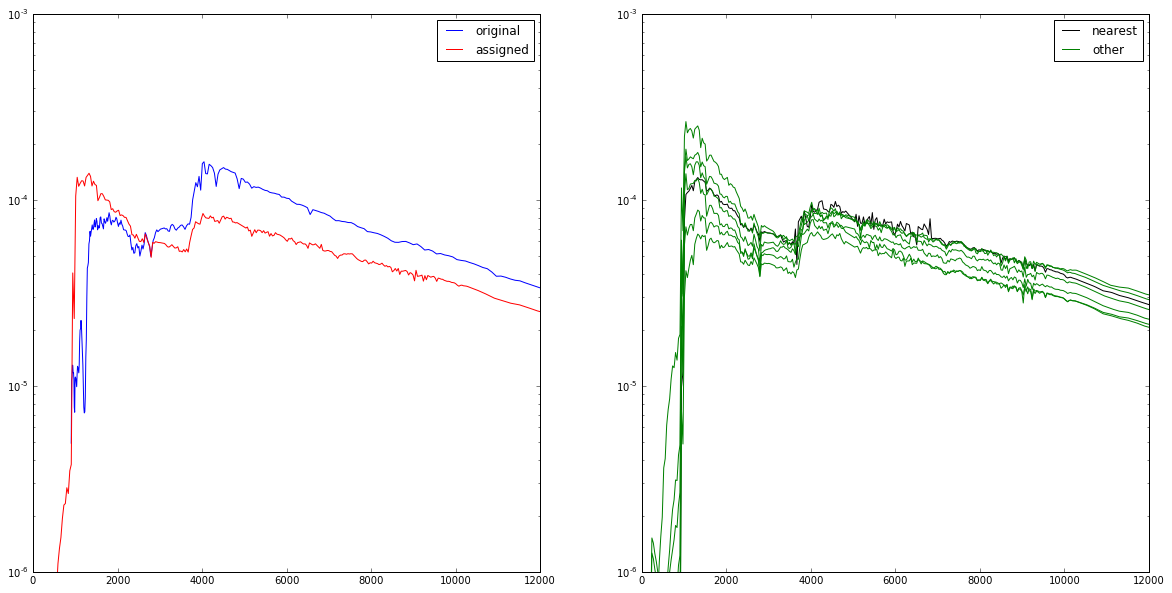

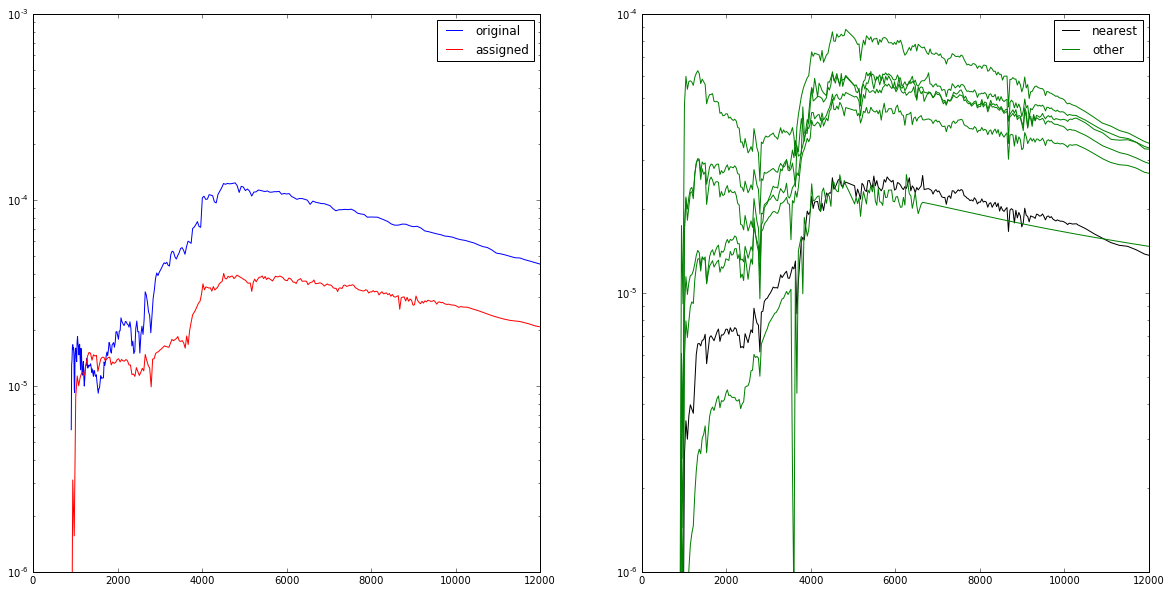

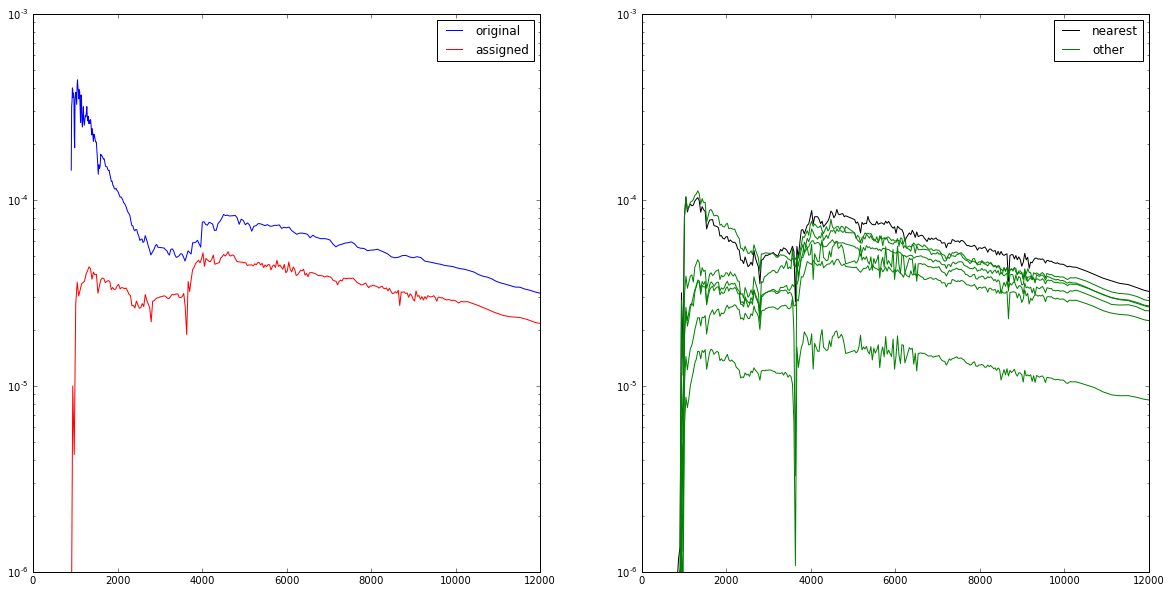

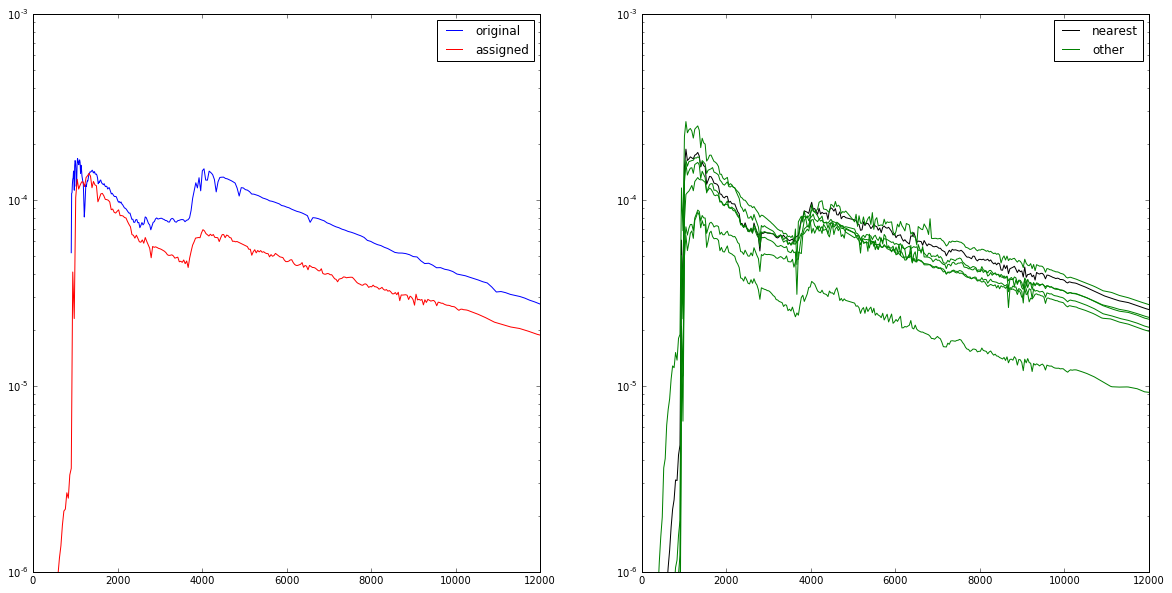

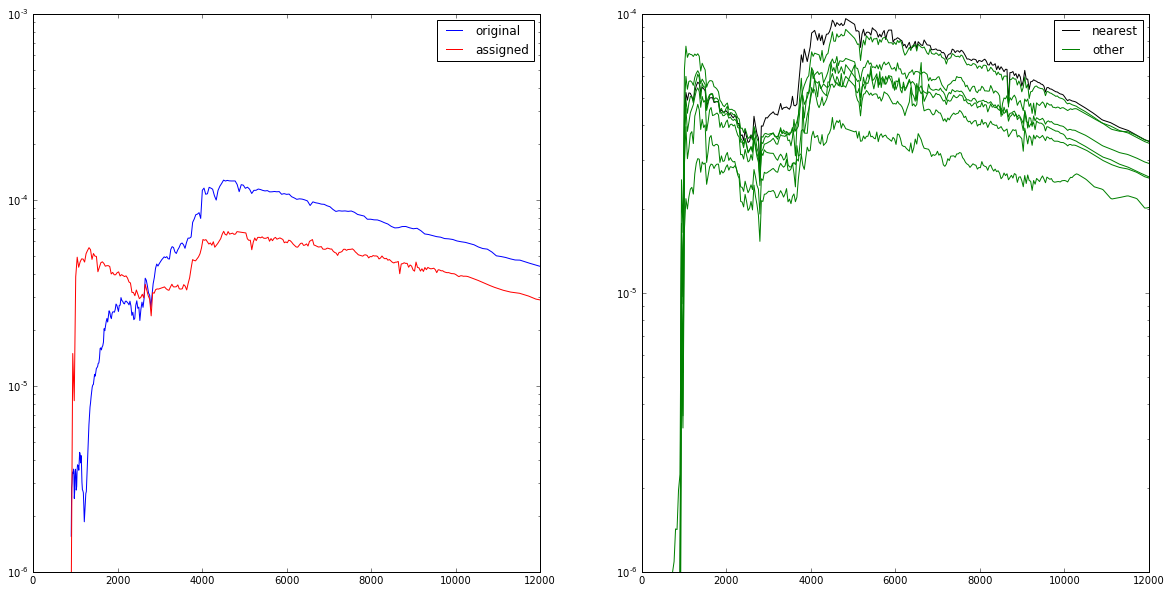

In [52]:
### select nshow galaxies at random
import random
nshow = 5
irand = random.sample(range(len(galacticus_sim._data)), nshow)

for j in irand:
    
    # randomly selected row of dataframe
    row = galacticus_sim._data.iloc[j]
    
    redshift = row['redshift']
    absMag = (filterList[3], row['LSST_i:rest:dustAtlas'])
    
    # grab galacticus spectrum
    lambda_eff, f_lambda, inorm = galacticus.get_seds(wls, galacticus_narrow_bands, row)
    
    # get LSST rest-frame colors
    mags = galacticus.get_lsst_mags(galacticus_LSST_rfbands, row)
    colors = galacticus.turn_mags_to_colors(mags, ipivot)
    
    # normalise so integrates to 1
    norm = np.sum(f_lambda*lambda_eff*0.01)
    
    # first plot simulated galaxy spectrum
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(121)
    ax.plot(lambda_eff, f_lambda/norm, color='blue', label='original')
    
    # get nearest neighbor Brown composite SED
    waveLen, sed_comp, sed_all = nearestNeighbor.get_composite_spectrum(colors)
    
    # plot composite SED too
    ax.plot(waveLen, sed_comp, color='red', label='assigned')
    ax.set_yscale('log')
    ax.set_xlim([0,12000])
    ylims = ax.get_ylim()
    ax.set_ylim([1e-6,ylims[1]])
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels)
    
    # plot all the nth nearest neighbor SEDs on separate panel
    ax = fig.add_subplot(122)
    for i in range(sed_all.shape[1]):
        if (i<1):
            ax.plot(waveLen, sed_all[:,i], color='black', label='nearest')
        elif (i<2):
            ax.plot(waveLen, sed_all[:,i], color='green', label='other')
        else:
            ax.plot(waveLen, sed_all[:,i], color='green')
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels)
    ax.set_yscale('log')
    ax.set_xlim([0,12000])
    ylims = ax.get_ylim()
    ax.set_ylim([1e-6,ylims[1]])
    
    # create new SED
    sed = sedFilter.SED(waveLen, sed_comp)
            
    # simulate observed magnitude from new spectrum
    pLSST = phot.ObsMag(sed, filterDict, cosmoModel, LsstErrorModel)
    
    # get redshift and absolute magnitude from galacticus
    print "redshift =", redshift, "M_i =", absMag[1]
    
    # get observed magnitude in each filter
    for i in xrange(len(filterDict)):
        
        # observed magnitude, magnitude error, true magnitude
        m, em, mt = pLSST.simulateObservation(filterList[i], redshift, absMag)
        print "observed magnitude, error in", filterList[i] , m , em
    print ""
        

# Run SED assignment + simulation of observations on full simulation

In [53]:
# total number of galaxies in the Galacticus simulation
ngals = galacticus_sim.get_number_of_rows()

# array that will store the new magnitudes from the pasted Brown spectra
new_mags = np.zeros((ngals, nFilters*3))

ii = 0
ibad = 0
for index, row in galacticus_sim._data.iterrows():
    
    #print index,
    
    # grab galacticus spectrum
    lambda_eff, f_lambda, inorm = galacticus.get_seds(wls, galacticus_narrow_bands, row)
    
    # get LSST rest-frame colors
    mags = galacticus.get_lsst_mags(galacticus_LSST_rfbands, row)
    colors = galacticus.turn_mags_to_colors(mags, ipivot)
    
    # get nearest neighbor Brown composite SED
    waveLen, sed_comp, sed_all = nearestNeighbor.get_composite_spectrum(colors)
            
    # create new SED
    sed = sedFilter.SED(waveLen, sed_comp)
            
    # simulate observed magnitude from new spectrum
    pLSST = phot.ObsMag(sed, filterDict, cosmoModel, LsstErrorModel)
    
    # get redshift and absolute magnitude from galacticus
    z = row['redshift']
    absMag = (filterList[3], row['LSST_i:rest:dustAtlas'])
    
    # get observed magnitude in each filter
    ifilt = 0
    for i in xrange(len(filterDict)):
        
        # observed magnitude, magnitude error, true magnitude
        m, em, mt = pLSST.simulateObservation(filterList[i], z, absMag)
        #print mt,
        
        if (mt<5.):
            
            
            # plot simulated galaxy spectrum
            fig = plt.figure(figsize=(20,10))
            ax = fig.add_subplot(121)
            ax.plot(lambda_eff, f_sim/norm, color='blue')
            ax.plot(waveLen, sed_comp, color='red')
            ax.set_yscale('log')
            ax.set_xlim([0,12000])
            ylims = ax.get_ylim()
            ax.set_ylim([1e-6,ylims[1]])
            ax.set_title(str(mt) + " " + filterList[i] + " " + str(z) + " " + str(absMag[1]) )
            
            ibad+=1
        
        
        
        # store in array
        #print index,
        new_mags[index, 3*i] = mt
        new_mags[index, 3*i+1] = m
        new_mags[index, 3*i+2] = em
    #print ""
    
    if ibad>5:
        break
        
    #if ii>500 and ii<550:
    #    print index
        
    ii += 1
    #if (ii>550):
    #    break
        
        
# Add new columns for observed magnitudes to dataframe
galacticus_df = galacticus_sim._data

# These are the new column names
new_column_names = ["brown_LSST_u_true", "brown_LSST_u_obs", "brown_LSST_u_obserr",
                    "brown_LSST_g_true", "brown_LSST_g_obs", "brown_LSST_g_obserr",
                    "brown_LSST_r_true", "brown_LSST_r_obs", "brown_LSST_r_obserr",
                    "brown_LSST_i_true", "brown_LSST_i_obs", "brown_LSST_i_obserr",
                    "brown_LSST_z_true", "brown_LSST_z_obs", "brown_LSST_z_obserr",
                    "brown_LSST_y_true", "brown_LSST_y_obs", "brown_LSST_y_obserr"]


# Loop over each filter and add the magnitudes
for i in range(nFilters):
    
    tmag_name = new_column_names[3*i]
    mag_name = new_column_names[3*i+1]
    err_name = new_column_names[3*i+2]
    
    galacticus_df[tmag_name] = new_mags[:,3*i]
    galacticus_df[mag_name] = new_mags[:,3*i+1]
    galacticus_df[err_name] = new_mags[:,3*i+2]

In [54]:
galacticus_df.head()

,LSST_g:observed:,LSST_g:observed:dustAtlas,LSST_g:rest:,LSST_g:rest:dustAtlas,LSST_i:observed:,LSST_i:observed:dustAtlas,LSST_i:rest:,LSST_i:rest:dustAtlas,LSST_r:observed:,LSST_r:observed:dustAtlas,...,brown_LSST_r_obserr,brown_LSST_i_true,brown_LSST_i_obs,brown_LSST_i_obserr,brown_LSST_z_true,brown_LSST_z_obs,brown_LSST_z_obserr,brown_LSST_y_true,brown_LSST_y_obs,brown_LSST_y_obserr
0,25.401573,25.405556,-21.101139,-21.099148,25.299789,25.304981,-21.451208,-21.448709,25.273066,25.280964,...,0.042279,24.413236,24.475912,0.071958,24.231307,24.341477,0.120139,24.059591,24.346533,0.289943
1,27.995468,28.106739,-18.005802,-17.949017,27.955027,28.096121,-18.026327,-17.998659,27.937145,28.137011,...,0.352996,26.938152,27.011358,0.573054,26.861222,26.701852,0.913012,26.799437,26.515864,1.707073
2,26.174345,28.594275,-20.865973,-19.689339,25.894253,27.631622,-21.189142,-20.240803,25.923426,27.775881,...,0.211635,26.208259,25.915327,0.330040,25.930100,25.442308,0.482313,25.656657,26.266677,0.919569
3,24.863661,24.863661,-21.611115,-21.611115,24.703398,24.703823,-21.746719,-21.746719,24.684376,24.684376,...,0.019597,23.527364,23.519020,0.032833,23.418985,23.436034,0.058553,23.334691,23.392363,0.158349
4,22.877632,23.527185,-22.641233,-22.062075,22.934792,23.509768,-22.687519,-22.173326,22.840488,23.660938,...,0.010705,22.827361,22.820599,0.017775,22.738547,22.746474,0.031749,22.676202,22.704420,0.089213


# Sanity check the true Brown magnitudes

u band:
60 detected in Galacticus but not in Brown 79 detected in Brown but not in Galacticus
Mean M_i of gals not detected in Brown: 100.0
Mean M_i of gals not detected in Galacticus: -20.0459628045 

g band:
60 detected in Galacticus but not in Brown 51 detected in Brown but not in Galacticus
Mean M_i of gals not detected in Brown: 100.0
Mean M_i of gals not detected in Galacticus: -19.2710228714 

r band:
63 detected in Galacticus but not in Brown 42 detected in Brown but not in Galacticus
Mean M_i of gals not detected in Brown: 100.0
Mean M_i of gals not detected in Galacticus: -18.9720518248 

i band:
62 detected in Galacticus but not in Brown 52 detected in Brown but not in Galacticus
Mean M_i of gals not detected in Brown: 100.0
Mean M_i of gals not detected in Galacticus: -19.8826682934 

z band:
48 detected in Galacticus but not in Brown 53 detected in Brown but not in Galacticus
Mean M_i of gals not detected in Brown: 100.0
Mean M_i of gals not detected in Galacticus: -20.231

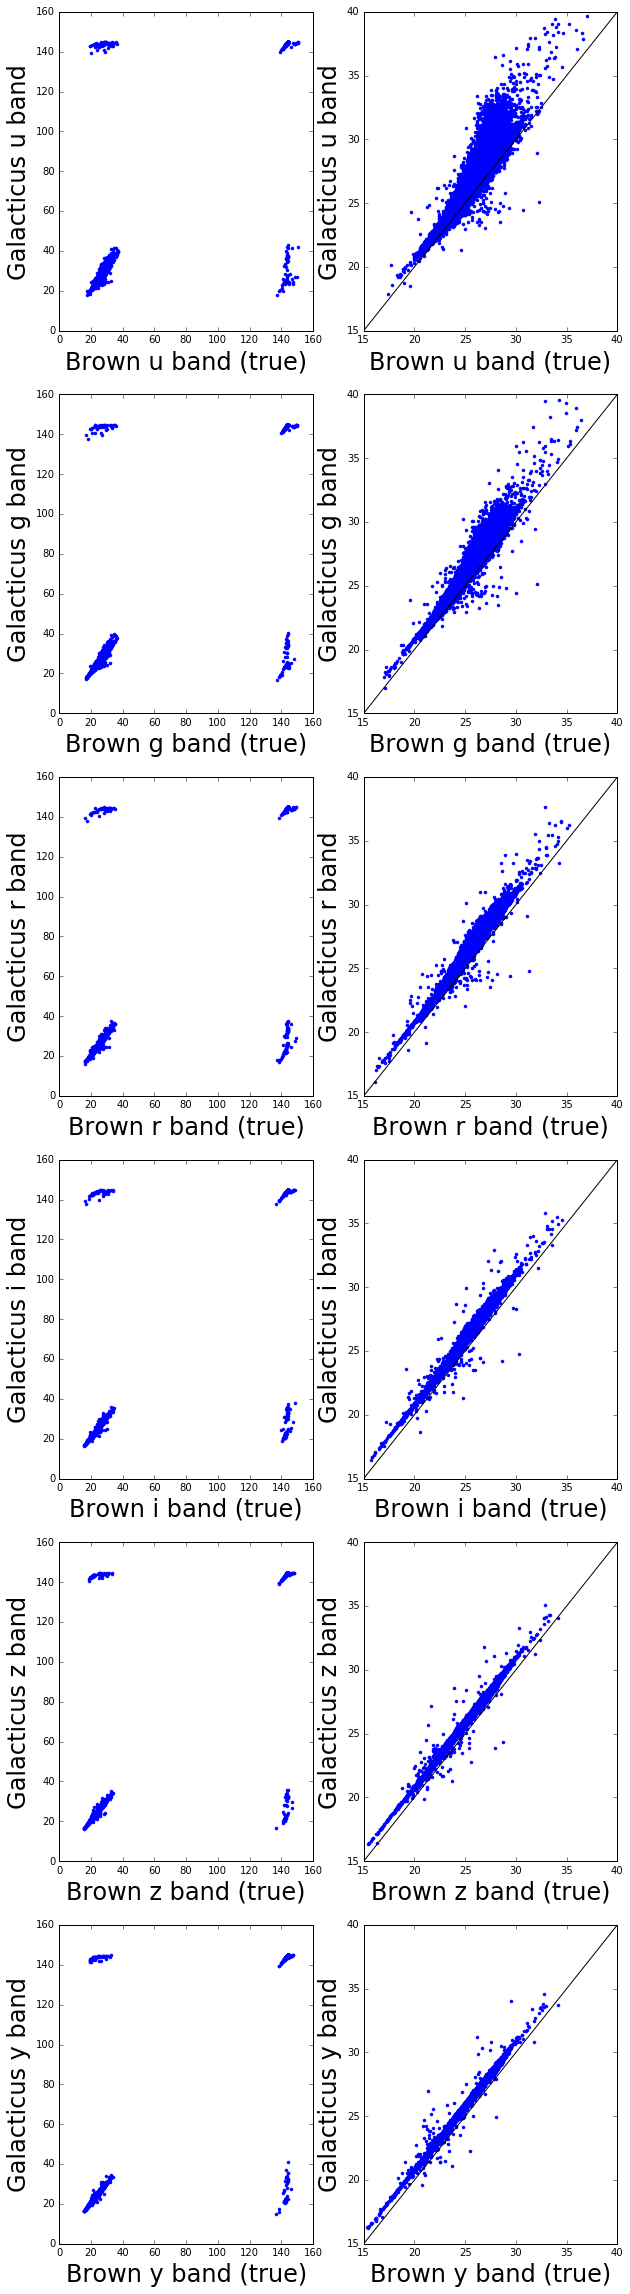

In [55]:
fig = plt.figure(figsize=(10,40))

filts = ['u', 'g', 'r', 'i', 'z', 'y']

i = 1
for f in filts:
    
    fg = f
    if (f=='y'):
        fg = 'y4'

    ax = fig.add_subplot(6,2,i)
    ax.plot(galacticus_df["brown_LSST_" + f + "_true"],
           galacticus_df["LSST_" + fg + ":observed:dustAtlas"],
           linestyle='none', marker='.')
    ax.set_xlabel('Brown ' + f + ' band (true)', fontsize=24)
    ax.set_ylabel('Galacticus ' + f + ' band', fontsize=24)

    i+=1

    ax = fig.add_subplot(6,2,i)
    ax.plot(galacticus_df["brown_LSST_" + f + "_true"],
            galacticus_df["LSST_" + fg + ":observed:dustAtlas"],
            linestyle='none', marker='.')
    ax.plot([15,40],[15,40], linestyle='solid', color='black')
    ax.set_xlabel('Brown ' + f + ' band (true)', fontsize=24)
    ax.set_ylabel('Galacticus ' + f + ' band', fontsize=24)
    ax.set_xlim([15., 40.])
    ax.set_ylim([15., 40.])
    
    i+=1
    
    print f ,"band:"
    iBrownNonDet = (galacticus_df["brown_LSST_" + f + "_true"]>80.) & \
                   (galacticus_df["LSST_" + fg + ":observed:dustAtlas"]<80.)
        
    iGalacNonDet = (galacticus_df["brown_LSST_" + f + "_true"]<80.) & \
                   (galacticus_df["LSST_" + fg + ":observed:dustAtlas"]>80.)
        
    print len(galacticus_df[iBrownNonDet]), "detected in Galacticus but not in Brown",
    
    print len(galacticus_df[iGalacNonDet]), "detected in Brown but not in Galacticus"
    print "Mean M_i of gals not detected in Brown:",
    print galacticus_df['LSST_i:rest:dustAtlas'][iBrownNonDet].values.mean()
    print "Mean M_i of gals not detected in Galacticus:",
    print galacticus_df['LSST_i:rest:dustAtlas'][iGalacNonDet].values.mean(),"\n"

# Add colors to Galacticus dataframe

In [56]:
# Add the true "Brown" colors
mag_columns = ["brown_LSST_u_true", "brown_LSST_g_true", "brown_LSST_r_true",
               "brown_LSST_i_true", "brown_LSST_z_true", "brown_LSST_y_true"]
interface.add_colors_to_df(galacticus_df, mag_columns)

# Add the observed "Brown" colors
mag_columns = ["brown_LSST_u_obs", "brown_LSST_g_obs", "brown_LSST_r_obs",
               "brown_LSST_i_obs", "brown_LSST_z_obs", "brown_LSST_y_obs"]
interface.add_colors_to_df(galacticus_df, mag_columns)

# Add the observed original Galacticus colors
mag_columns = ["LSST_u:observed:dustAtlas", "LSST_g:observed:dustAtlas", 
               "LSST_r:observed:dustAtlas", "LSST_i:observed:dustAtlas",
               "LSST_z:observed:dustAtlas", "LSST_y4:observed:dustAtlas",]
interface.add_colors_to_df(galacticus_df, mag_columns)


# Compare true colors

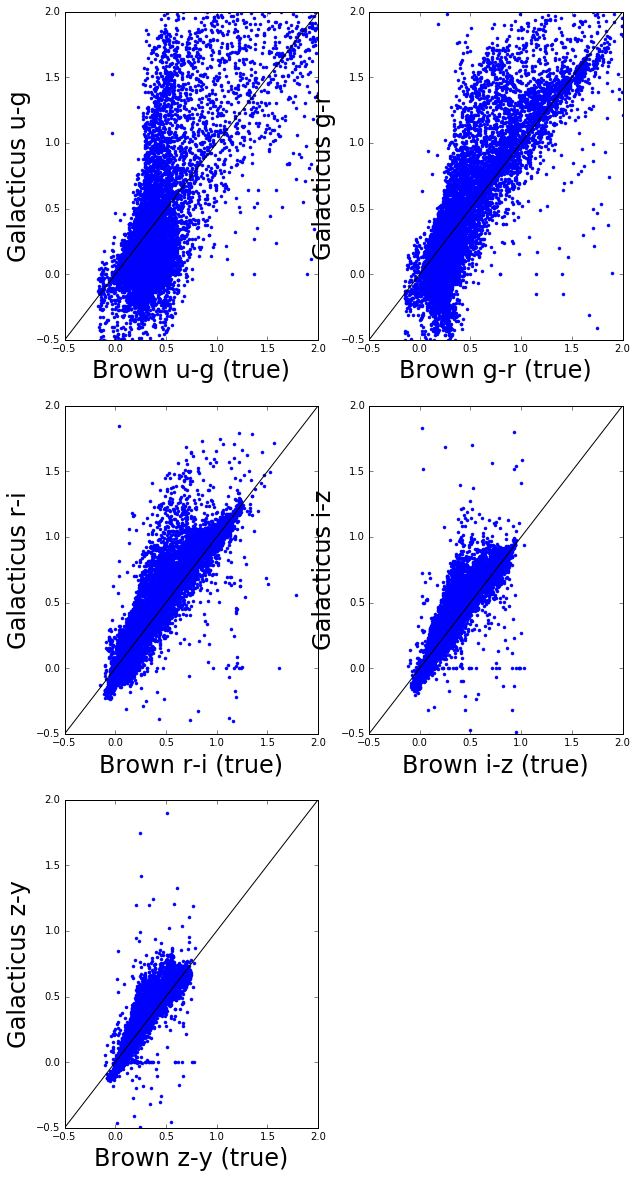

In [57]:
bins = np.arange(-1,1,0.1)

igold = (galacticus_df["brown_LSST_i_true"]<25.3)

fig = plt.figure(figsize=(10,20))

filts = ['u', 'g', 'r', 'i', 'z', 'y']


for i in range(len(filts)-1):
    
    f1 = filts[i]
    f2 = filts[i+1]
    
    f1g = filts[i]
    f2g = filts[i+1]
    
    if (f1g=='y'):
        f1g = 'y4'
        
    if (f2g=='y'):
        f2g = 'y4'

    ax = fig.add_subplot(3,2,i+1)

    
    ax.plot(galacticus_df["brown_LSST_" + f1 + "_true-brown_LSST_" + f2 + "_true"][igold],
    galacticus_df["LSST_" + f1g + ":observed:dustAtlas-LSST_" + f2g + ":observed:dustAtlas"][igold],
    linestyle='none', marker='.')
    ax.set_xlabel('Brown ' + f1 + '-' + f2 + ' (true)', fontsize=24)
    ax.set_ylabel('Galacticus ' + f1 + '-' + f2, fontsize=24)
    ax.set_xlim([-0.5,2])
    ax.set_ylim([-0.5,2])
    ax.plot([-0.5,2],[-0.5,2], linestyle='solid', color='black')





# (True) Color distribution with redshift

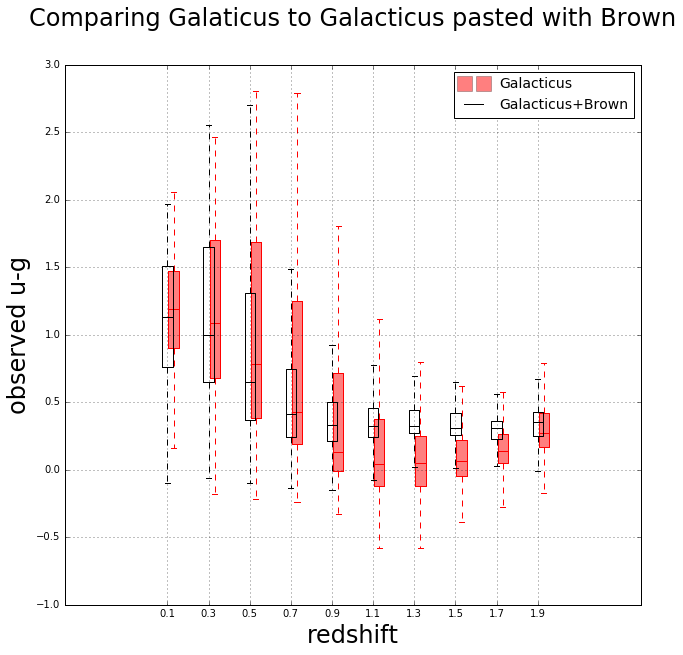

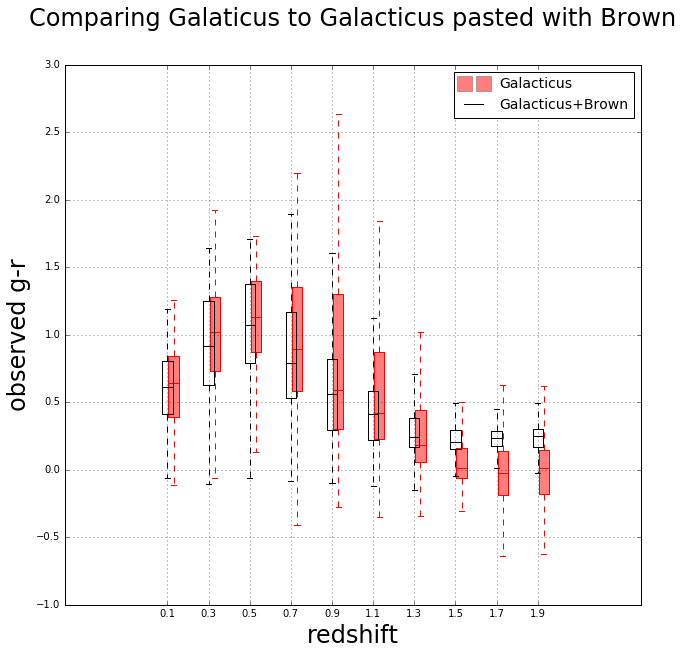

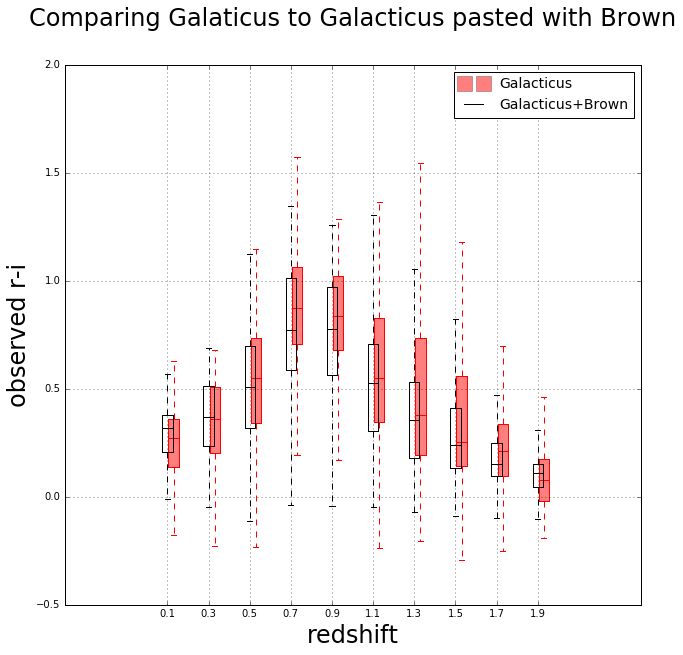

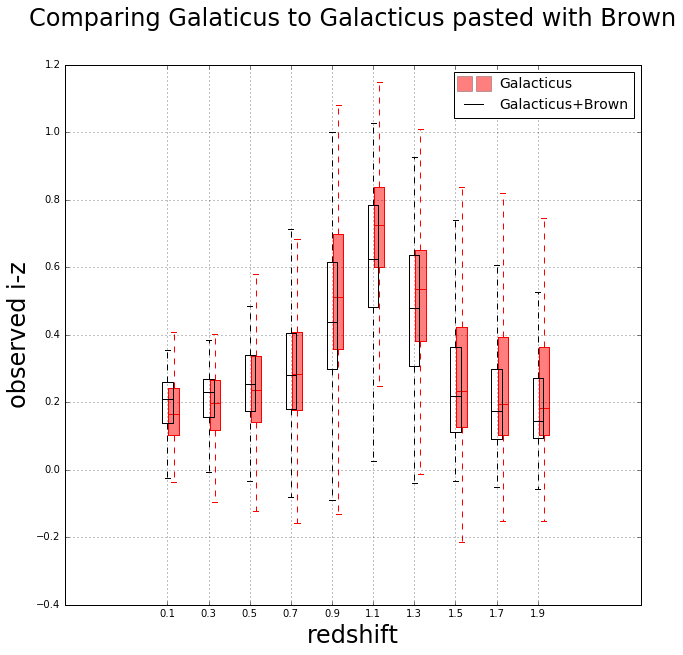

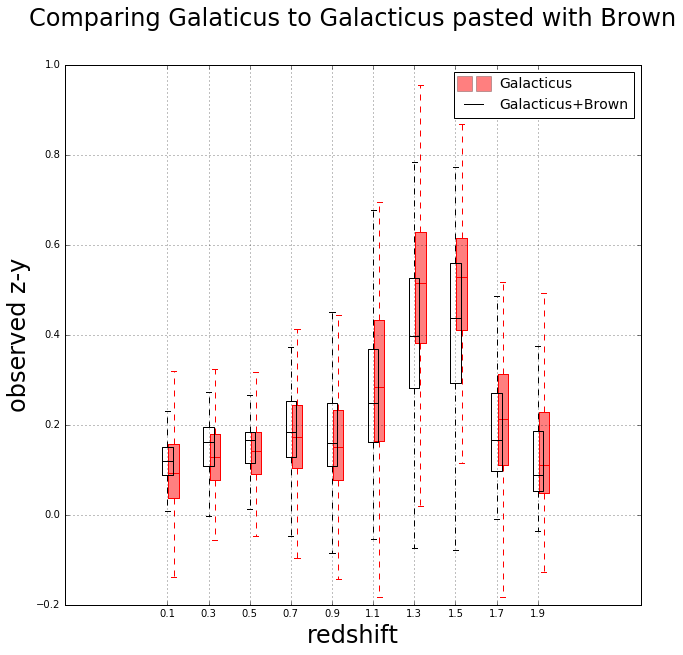

In [58]:
import plot_color as pc

# first cut out all the 

# redshift binning to make the plots
zmin = 0.
zmax = 2.
dbin = 0.2

# name of redshift column in each dataframe (galacticus, cfht-subaru)
z_columns = ["redshift", "redshift"]

# for each color list of: [name_in_galacticus_v0, name_in_galacticus_v1]
color_pairs = [['LSST_u:observed:dustAtlas-LSST_g:observed:dustAtlas', 
                'brown_LSST_u_true-brown_LSST_g_true'], 
               ['LSST_g:observed:dustAtlas-LSST_r:observed:dustAtlas', 
                'brown_LSST_g_true-brown_LSST_r_true'], 
               ['LSST_r:observed:dustAtlas-LSST_i:observed:dustAtlas', 
                'brown_LSST_r_true-brown_LSST_i_true'], 
               ['LSST_i:observed:dustAtlas-LSST_z:observed:dustAtlas', 
                'brown_LSST_i_true-brown_LSST_z_true'], 
               ['LSST_z:observed:dustAtlas-LSST_y4:observed:dustAtlas', 
                'brown_LSST_z_true-brown_LSST_y_true'] ]
    
# names of the colors to go on the plot axes
color_names = ['u-g', 'g-r', 'r-i', 'i-z', 'z-y']


for color_name, color_columns in zip(color_names, color_pairs):
    
    # initalise axes to add boxplots to
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)

    legend_handles = pc.color_boxplot(
                     ax,                 # axes to plot on  
                     galacticus_df[igold],      # dataframe 1
                     galacticus_df[igold],      # dataframe 2
                     color_columns,      # list of names of each color in [[df1, df2]]
                     z_columns,          # name of redshift column in [df1, df2] 
                     zmin, zmax, dbin,   # zmin, zmax, dbin to define the redshift binning
                     zbin_offset=0.03,   # how much to offset 2nd set of color plots by
                     color1='red',       # dataframe 1 will be this color, and shaded 
                     color2='black',     # dataframe 2 will be outlined in this color 
                     boxwidth=0.05,      # how wide in redshift boxplots appear
                     showfliers=False    # show the flier points or not
                     )
    
    ax.set_xlabel('redshift', fontsize=24)
    ax.set_ylabel('observed ' + color_name, fontsize=24)
    fig.suptitle('Comparing Galaticus to Galacticus pasted with Brown', fontsize=24)
    ax.set_title('')
    
    # the legend will come out with text 'data1' and 'data2'
    # fix it to whatever you like with the below
    
    # fix legend    
    labels = ['Galacticus', 'Galacticus+Brown']
    ax.legend(legend_handles, labels, prop={'size':14}, loc='upper right')

# Be careful redshift correlates with index!

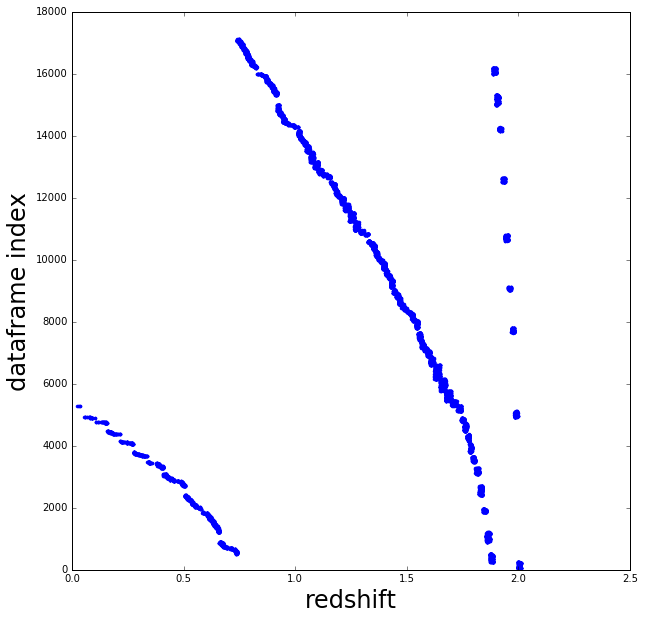

In [59]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(galacticus_df.redshift, galacticus_df.index, linestyle='none', marker='.')
ax.set_xlabel('redshift', fontsize=24)
ax.set_ylabel('dataframe index', fontsize=24)

# Make new index

In [60]:
# perturb order of dataframe
galacticus_df_final = galacticus_df.sample(frac=1)

In [61]:
galacticus_df_final.head()

,LSST_g:observed:,LSST_g:observed:dustAtlas,LSST_g:rest:,LSST_g:rest:dustAtlas,LSST_i:observed:,LSST_i:observed:dustAtlas,LSST_i:rest:,LSST_i:rest:dustAtlas,LSST_r:observed:,LSST_r:observed:dustAtlas,...,brown_LSST_u_obs-brown_LSST_g_obs,brown_LSST_g_obs-brown_LSST_r_obs,brown_LSST_r_obs-brown_LSST_i_obs,brown_LSST_i_obs-brown_LSST_z_obs,brown_LSST_z_obs-brown_LSST_y_obs,LSST_u:observed:dustAtlas-LSST_g:observed:dustAtlas,LSST_g:observed:dustAtlas-LSST_r:observed:dustAtlas,LSST_r:observed:dustAtlas-LSST_i:observed:dustAtlas,LSST_i:observed:dustAtlas-LSST_z:observed:dustAtlas,LSST_z:observed:dustAtlas-LSST_y4:observed:dustAtlas
12214,27.392885,27.654072,-17.700583,-17.637577,27.035639,27.143009,-17.917522,-17.880529,27.270832,27.402073,...,-0.217886,0.674852,0.127213,-0.138750,1.124713,-0.103085,0.251999,0.259064,0.732224,0.228981
9521,23.918350,29.868153,-21.128862,-19.327761,23.944134,26.913288,-21.577515,-20.233589,24.034843,28.518017,...,-0.902776,0.671678,1.246938,0.364756,-73.236784,2.549500,1.350136,1.604729,0.658415,0.674524
1760,26.340172,26.346483,-17.805204,-17.804850,24.530657,24.531130,-18.362743,-18.362907,25.243496,25.245131,...,0.201937,0.793738,0.653997,0.157609,0.278461,0.720434,1.101353,0.714001,0.212641,0.148300
1326,26.482944,26.493593,-18.473032,-18.469616,24.135284,24.139057,-19.319073,-19.312025,25.127914,25.138643,...,0.034925,1.088337,0.903287,0.349978,0.107702,1.385284,1.354950,0.999586,0.356653,0.243166
16861,25.695454,25.821770,-18.451218,-18.378590,24.403860,24.485060,-18.545015,-18.505808,25.198565,25.291719,...,-0.038266,0.125188,0.543821,-0.043037,-0.195815,0.254080,0.530050,0.806660,0.056955,0.031885


In [62]:
# add column that is just 0 to n-1 galaxies
galacticus_df_final["galacID"] = range(0,len(galacticus_df_final))

In [63]:
galacticus_df_final.head()

,LSST_g:observed:,LSST_g:observed:dustAtlas,LSST_g:rest:,LSST_g:rest:dustAtlas,LSST_i:observed:,LSST_i:observed:dustAtlas,LSST_i:rest:,LSST_i:rest:dustAtlas,LSST_r:observed:,LSST_r:observed:dustAtlas,...,brown_LSST_g_obs-brown_LSST_r_obs,brown_LSST_r_obs-brown_LSST_i_obs,brown_LSST_i_obs-brown_LSST_z_obs,brown_LSST_z_obs-brown_LSST_y_obs,LSST_u:observed:dustAtlas-LSST_g:observed:dustAtlas,LSST_g:observed:dustAtlas-LSST_r:observed:dustAtlas,LSST_r:observed:dustAtlas-LSST_i:observed:dustAtlas,LSST_i:observed:dustAtlas-LSST_z:observed:dustAtlas,LSST_z:observed:dustAtlas-LSST_y4:observed:dustAtlas,galacID
12214,27.392885,27.654072,-17.700583,-17.637577,27.035639,27.143009,-17.917522,-17.880529,27.270832,27.402073,...,0.674852,0.127213,-0.138750,1.124713,-0.103085,0.251999,0.259064,0.732224,0.228981,0
9521,23.918350,29.868153,-21.128862,-19.327761,23.944134,26.913288,-21.577515,-20.233589,24.034843,28.518017,...,0.671678,1.246938,0.364756,-73.236784,2.549500,1.350136,1.604729,0.658415,0.674524,1
1760,26.340172,26.346483,-17.805204,-17.804850,24.530657,24.531130,-18.362743,-18.362907,25.243496,25.245131,...,0.793738,0.653997,0.157609,0.278461,0.720434,1.101353,0.714001,0.212641,0.148300,2
1326,26.482944,26.493593,-18.473032,-18.469616,24.135284,24.139057,-19.319073,-19.312025,25.127914,25.138643,...,1.088337,0.903287,0.349978,0.107702,1.385284,1.354950,0.999586,0.356653,0.243166,3
16861,25.695454,25.821770,-18.451218,-18.378590,24.403860,24.485060,-18.545015,-18.505808,25.198565,25.291719,...,0.125188,0.543821,-0.043037,-0.195815,0.254080,0.530050,0.806660,0.056955,0.031885,4


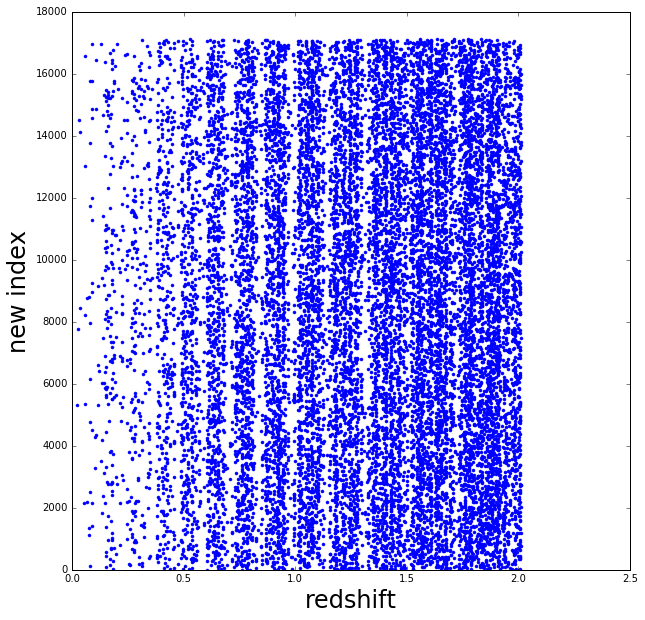

In [64]:
# double check index not correlated with redshift
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(galacticus_df_final.redshift, galacticus_df_final.galacID, linestyle='none', marker='.')
ax.set_xlabel('redshift', fontsize=24)
ax.set_ylabel('new index', fontsize=24)

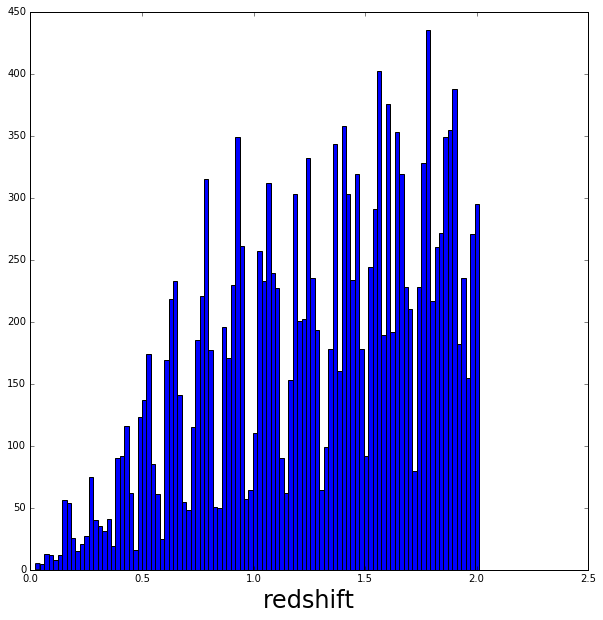

In [65]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.hist(galacticus_df_final.redshift,100)
ax.set_xlabel('redshift', fontsize=24)


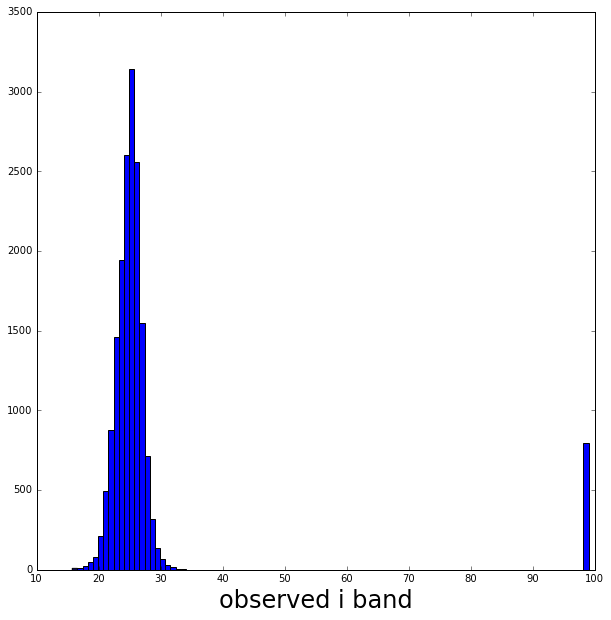

In [66]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.hist(galacticus_df_final["brown_LSST_i_obs"],100)
ax.set_xlabel('observed i band', fontsize=24)

In [67]:
print galacticus_df_final.columns

Index([                                    u'LSST_g:observed:',
                                  u'LSST_g:observed:dustAtlas',
                                               u'LSST_g:rest:',
                                      u'LSST_g:rest:dustAtlas',
                                           u'LSST_i:observed:',
                                  u'LSST_i:observed:dustAtlas',
                                               u'LSST_i:rest:',
                                      u'LSST_i:rest:dustAtlas',
                                           u'LSST_r:observed:',
                                  u'LSST_r:observed:dustAtlas',
       ...
                          u'brown_LSST_g_obs-brown_LSST_r_obs',
                          u'brown_LSST_r_obs-brown_LSST_i_obs',
                          u'brown_LSST_i_obs-brown_LSST_z_obs',
                          u'brown_LSST_z_obs-brown_LSST_y_obs',
        u'LSST_u:observed:dustAtlas-LSST_g:observed:dustAtlas',
        u'LSST_g:observed:dus

# Write to FITS

## Grab relevant parts of dataframe only

In [68]:
# column names will be: galacID, redshift, ra, dec, LSST[x], errLSST[x]
import pandas as pd

# observed LSST magnitudes
obs_mags = ["brown_LSST_u_obs", "brown_LSST_g_obs", "brown_LSST_r_obs", 
            "brown_LSST_i_obs", "brown_LSST_z_obs", "brown_LSST_y_obs"]
err_mags = ["brown_LSST_u_obserr", "brown_LSST_g_obserr", "brown_LSST_r_obserr", 
            "brown_LSST_i_obserr", "brown_LSST_z_obserr", "brown_LSST_y_obserr"]

# take subset of dataframe and deep copy to new dataframe
photoZcatalog = pd.DataFrame(
    galacticus_df_final[["galacID", "redshift", "ra", "dec"] + obs_mags + err_mags])
photoZcatalog.head()

,galacID,redshift,ra,dec,brown_LSST_u_obs,brown_LSST_g_obs,brown_LSST_r_obs,brown_LSST_i_obs,brown_LSST_z_obs,brown_LSST_y_obs,brown_LSST_u_obserr,brown_LSST_g_obserr,brown_LSST_r_obserr,brown_LSST_i_obserr,brown_LSST_z_obserr,brown_LSST_y_obserr
12214,0,1.190073,1.566000,1.903207,26.525252,26.743138,26.068286,25.941073,26.079823,24.955111,0.816747,0.254937,0.194657,0.302081,0.392270,0.834896
9521,1,1.407712,0.602704,0.457576,27.148963,28.051739,27.380061,26.133122,25.768366,99.005150,2.045041,0.754699,0.458743,0.313688,0.343847,0.515277
1760,2,0.606251,0.933041,-0.730134,25.377909,25.175972,24.382234,23.728237,23.570628,23.292167,0.395501,0.090614,0.036956,0.040743,0.066234,0.165341
1326,3,0.654632,-0.924192,-2.107133,25.330889,25.295964,24.207628,23.304341,22.954363,22.846662,0.510145,0.099181,0.032545,0.027616,0.040341,0.095315
16861,4,0.759420,0.668790,-2.012761,24.388847,24.427113,24.301925,23.758104,23.801141,23.996956,0.175350,0.049343,0.035033,0.044536,0.077135,0.212519


## Change column names to approved format

In [69]:
import re
filts = ['u', 'g', 'r', 'i', 'z', 'y']
obs_names = ["LSSTu", "LSSTg", "LSSTr", "LSSTi", "LSSTz", "LSSTy"]
err_names = ["errLSSTu", "errLSSTg", "errLSSTr", "errLSSTi", "errLSSTz", "errLSSTy"]

new_names = []
for i, col in enumerate(photoZcatalog.columns):
    
    isFound = False
    for j, f in enumerate(filts):
        mobs = ".*" + f + "_obs$"  
        eobs = ".*" + f + "_obserr$"  
        if re.match(mobs, col):
            new_names.append(obs_names[j])
            isFound = True
        elif re.match(eobs, col):
            new_names.append(err_names[j])
            isFound = True
    if not isFound:
        new_names.append(col)

photoZcatalog.columns = new_names


In [70]:
print photoZcatalog.columns

Index([ u'galacID', u'redshift',       u'ra',      u'dec',    u'LSSTu',
          u'LSSTg',    u'LSSTr',    u'LSSTi',    u'LSSTz',    u'LSSTy',
       u'errLSSTu', u'errLSSTg', u'errLSSTr', u'errLSSTi', u'errLSSTz',
       u'errLSSTy'],
      dtype='object')


## Place data in FITS table

In [71]:
import astropy
def convert_df_to_fitstable(df):

    fits_columns = []
    for column in df:
    
        # numpy doesn't allow a dtype with a unicode column name
        # so convert to str
        col_name = str(df[column].name)
        col_data = df[column].values
    
        format_column = 'D'
    
        if col_name == "galacID":
            col_data.astype(np.int64, copy=False)
            format_column = 'K'
        print col_name, type(col_data[0]), format_column, type(col_name)
    
    
        col = fits.Column(name=col_name, format=format_column, array=col_data)
        fits_columns.append(col)


    cols = fits.ColDefs(fits_columns)
    tbhdu = fits.BinTableHDU.from_columns(cols)
    return tbhdu

def add_comment_to_header(comment):
    
    prihdr = fits.Header()
    prihdr['COMMENT'] = comment
    prihdu = fits.PrimaryHDU(header=prihdr)
    
    return prihdu

def write_df_to_fits(df, outfile_name, comment=""):

    tbhdu = convert_df_to_fitstable(df)
    prihdu = add_comment_to_header(comment)
    thdulist = fits.HDUList([prihdu, tbhdu])
    thdulist.writeto(outfile_name)

In [72]:
mainfile = 'test_galacticus_catalog.fits'
comment =  "Derived from Galacticus simulation version BLAH. "
comment += "Pasted Brown SEDs via nearest neighbor method"
write_df_to_fits(photoZcatalog, mainfile, comment)

galacID <type 'numpy.int64'> K <type 'str'>
redshift <type 'numpy.float64'> D <type 'str'>
ra <type 'numpy.float64'> D <type 'str'>
dec <type 'numpy.float64'> D <type 'str'>
LSSTu <type 'numpy.float64'> D <type 'str'>
LSSTg <type 'numpy.float64'> D <type 'str'>
LSSTr <type 'numpy.float64'> D <type 'str'>
LSSTi <type 'numpy.float64'> D <type 'str'>
LSSTz <type 'numpy.float64'> D <type 'str'>
LSSTy <type 'numpy.float64'> D <type 'str'>
errLSSTu <type 'numpy.float64'> D <type 'str'>
errLSSTg <type 'numpy.float64'> D <type 'str'>
errLSSTr <type 'numpy.float64'> D <type 'str'>
errLSSTi <type 'numpy.float64'> D <type 'str'>
errLSSTz <type 'numpy.float64'> D <type 'str'>
errLSSTy <type 'numpy.float64'> D <type 'str'>


# Breaking into training and test sets

In [73]:
the_catalog = interface.ReadCosmoSim(mainfile)
catalog_df = the_catalog._data
catalog_df.head()

,galacID,redshift,ra,dec,LSSTu,LSSTg,LSSTr,LSSTi,LSSTz,LSSTy,errLSSTu,errLSSTg,errLSSTr,errLSSTi,errLSSTz,errLSSTy
0,0.0,1.190073,1.566000,1.903207,26.525252,26.743138,26.068286,25.941073,26.079823,24.955111,0.816747,0.254937,0.194657,0.302081,0.392270,0.834896
1,1.0,1.407712,0.602704,0.457576,27.148963,28.051739,27.380061,26.133122,25.768366,99.005150,2.045041,0.754699,0.458743,0.313688,0.343847,0.515277
2,2.0,0.606251,0.933041,-0.730134,25.377909,25.175972,24.382234,23.728237,23.570628,23.292167,0.395501,0.090614,0.036956,0.040743,0.066234,0.165341
3,3.0,0.654632,-0.924192,-2.107133,25.330889,25.295964,24.207628,23.304341,22.954363,22.846662,0.510145,0.099181,0.032545,0.027616,0.040341,0.095315
4,4.0,0.759420,0.668790,-2.012761,24.388847,24.427113,24.301925,23.758104,23.801141,23.996956,0.175350,0.049343,0.035033,0.044536,0.077135,0.212519


In [74]:
from sklearn import cross_validation

# split into training and testing
phot_train, phot_test, redshift_train, redshift_test = cross_validation.train_test_split(
    catalog_df[["LSSTu", "LSSTg", "LSSTr", "LSSTi", "LSSTz", "LSSTy"]], 
    catalog_df.redshift, test_size=0.4, random_state=0)

In [75]:
print type(phot_train), type(phot_test)
print type(redshift_train), type(redshift_test)
print phot_train.head()

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>
           LSSTu      LSSTg      LSSTr      LSSTi      LSSTz      LSSTy
4015   28.622868  26.146477  24.067361  22.940019  22.096668  21.897307
16392  28.926459  25.750591  24.793871  23.708364  23.035009  22.869098
12797  99.005150  99.005150  99.005150  99.005150  99.005150  99.005150
12502  25.217677  25.121535  24.741220  24.351218  24.258352  23.776153
12536  26.285118  25.041577  24.657617  24.122325  23.335844  23.113616


In [76]:
# Make four files: training set (photometry and redshifts)
# training set: ugrizy with errors and true redshifts
# test set: ugrizy with errors 
# test set with redshifts: as above with true redshifts
# test redshifts: just redshifts of test set

test_set = phot_test.join(catalog_df[["errLSSTu", "errLSSTg", 
                                      "errLSSTr", "errLSSTi", 
                                      "errLSSTz", "errLSSTy", 
                                      "galacID"]])

test_set.head()

,LSSTu,LSSTg,LSSTr,LSSTi,LSSTz,LSSTy,errLSSTu,errLSSTg,errLSSTr,errLSSTi,errLSSTz,errLSSTy,galacID
15983,27.091483,26.508529,26.350541,25.453187,25.144919,27.135417,0.957590,0.263643,0.175229,0.192473,0.242079,0.379174,15983.0
8987,25.123644,24.503805,24.171724,24.008814,23.515249,23.234447,0.216515,0.048496,0.032395,0.048160,0.063614,0.151042,8987.0
16771,26.446599,25.448217,24.960967,24.961150,24.337879,24.714337,0.406790,0.103910,0.072559,0.113974,0.176988,0.410469,16771.0
7501,25.320602,25.378591,24.998098,24.634419,24.266002,24.461918,0.405000,0.110234,0.074169,0.094487,0.112399,0.267398,7501.0
548,26.375593,26.426889,26.066089,25.574144,25.154889,24.404311,1.028765,0.319963,0.179312,0.165781,0.199094,0.430963,548.0


In [77]:
test_set_with_redshifts = test_set.join(redshift_test)
test_set_with_redshifts.head()

,LSSTu,LSSTg,LSSTr,LSSTi,LSSTz,LSSTy,errLSSTu,errLSSTg,errLSSTr,errLSSTi,errLSSTz,errLSSTy,galacID,redshift
15983,27.091483,26.508529,26.350541,25.453187,25.144919,27.135417,0.957590,0.263643,0.175229,0.192473,0.242079,0.379174,15983.0,1.409837
8987,25.123644,24.503805,24.171724,24.008814,23.515249,23.234447,0.216515,0.048496,0.032395,0.048160,0.063614,0.151042,8987.0,1.245601
16771,26.446599,25.448217,24.960967,24.961150,24.337879,24.714337,0.406790,0.103910,0.072559,0.113974,0.176988,0.410469,16771.0,1.753262
7501,25.320602,25.378591,24.998098,24.634419,24.266002,24.461918,0.405000,0.110234,0.074169,0.094487,0.112399,0.267398,7501.0,1.075981
548,26.375593,26.426889,26.066089,25.574144,25.154889,24.404311,1.028765,0.319963,0.179312,0.165781,0.199094,0.430963,548.0,0.944994


In [78]:
training_set = phot_train.join(catalog_df[["errLSSTu", "errLSSTg", 
                                           "errLSSTr", "errLSSTi", 
                                           "errLSSTz", "errLSSTy",
                                           "galacID"]]).join(redshift_train)

training_set.head()

,LSSTu,LSSTg,LSSTr,LSSTi,LSSTz,LSSTy,errLSSTu,errLSSTg,errLSSTr,errLSSTi,errLSSTz,errLSSTy,galacID,redshift
4015,28.622868,26.146477,24.067361,22.940019,22.096668,21.897307,1.624445,0.192501,0.028586,0.019525,0.017631,0.041880,4015.0,0.867596
16392,28.926459,25.750591,24.793871,23.708364,23.035009,22.869098,0.750740,0.171262,0.054289,0.040501,0.043498,0.102812,16392.0,0.875367
12797,99.005150,99.005150,99.005150,99.005150,99.005150,99.005150,117.377926,116.071330,115.928669,116.673996,117.453364,118.660780,12797.0,1.764595
12502,25.217677,25.121535,24.741220,24.351218,24.258352,23.776153,0.270732,0.075055,0.055493,0.071414,0.113056,0.294595,12502.0,0.907557
12536,26.285118,25.041577,24.657617,24.122325,23.335844,23.113616,0.355300,0.083831,0.049134,0.056054,0.054397,0.113283,12536.0,1.173730


In [79]:
test_redshifts = redshift_test.to_frame(name="redshift").join(catalog_df["galacID"])
test_redshifts.head()

,redshift,galacID
15983,1.409837,15983.0
8987,1.245601,8987.0
16771,1.753262,16771.0
7501,1.075981,7501.0
548,0.944994,548.0


In [80]:
outfile = "training_set_from_" + mainfile
comment =  "Subset of file " + mainfile + " for photo-z training"
write_df_to_fits(training_set, outfile, comment)

outfile = "test_set_from_" + mainfile
comment =  "Subset of file " + mainfile + " for photo-z testing"
write_df_to_fits(test_set, outfile, comment)

outfile = "test_set_with_redshifts_from_" + mainfile
comment =  "Subset of file " + mainfile + " for photo-z testing (with redshifts included)"
write_df_to_fits(test_set_with_redshifts, outfile, comment)

outfile = "test_set_redshifts_from_" + mainfile
comment =  "Redshifts that belong with file test_" + mainfile
write_df_to_fits(test_redshifts, outfile, comment)

LSSTu <type 'numpy.float64'> D <type 'str'>
LSSTg <type 'numpy.float64'> D <type 'str'>
LSSTr <type 'numpy.float64'> D <type 'str'>
LSSTi <type 'numpy.float64'> D <type 'str'>
LSSTz <type 'numpy.float64'> D <type 'str'>
LSSTy <type 'numpy.float64'> D <type 'str'>
errLSSTu <type 'numpy.float64'> D <type 'str'>
errLSSTg <type 'numpy.float64'> D <type 'str'>
errLSSTr <type 'numpy.float64'> D <type 'str'>
errLSSTi <type 'numpy.float64'> D <type 'str'>
errLSSTz <type 'numpy.float64'> D <type 'str'>
errLSSTy <type 'numpy.float64'> D <type 'str'>
galacID <type 'numpy.float64'> K <type 'str'>
redshift <type 'numpy.float64'> D <type 'str'>
LSSTu <type 'numpy.float64'> D <type 'str'>
LSSTg <type 'numpy.float64'> D <type 'str'>
LSSTr <type 'numpy.float64'> D <type 'str'>
LSSTi <type 'numpy.float64'> D <type 'str'>
LSSTz <type 'numpy.float64'> D <type 'str'>
LSSTy <type 'numpy.float64'> D <type 'str'>
errLSSTu <type 'numpy.float64'> D <type 'str'>
errLSSTg <type 'numpy.float64'> D <type 'str'>
err

NameError: name 'mainfile' is not defined